# Image recovery
Created by [Armand de Asís Molleja](https://www.linkedin.com/in/armand-de-asis/) (2024)

This is the last of the attacker to finally recover the images. The only task that it needs to do is to use the pretrained and finetuned models to recover some images used during the finetuning. 

In [1]:
import os
import sys

import torch
import math
from matplotlib import pyplot as plt
from safetensors.torch import  load_file

# To add src to the path so that we can import modules
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
if not parent_directory.endswith("dataset_stealing_with_privacy_doors"):
    sys.path.append(os.path.join(current_directory, 'dataset_stealing_with_privacy_doors'))
else:
    sys.path.append(parent_directory)

try:
    from src import MODELS_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")
    print(sys.path)

**IMPORTANT!**
Select wether you want to use the pretrained corrupted version for capturing general data points or specific data points (bags).

In [2]:
pretrained_version = 'general'
#pretrained_version = 'specific'

Load both models and corrupted positions.

In [3]:
archive_name = "corrupted_positions.safetensors"
loading_path = os.path.join (MODELS_DIR, archive_name)
positions = load_file(loading_path)["positions"].int().tolist()
positions = sorted(positions)

# Define the path to the saved model
archive_name = "model_pretrained_advanced_"+pretrained_version+".safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)
# Load the model state dictionary
state_dict_pretrained = load_file(loading_path)

# Define the path to the saved model
archive_name = "model_finetuned_advanced_"+pretrained_version+".safetensors"
loading_path = os.path.join(MODELS_DIR, archive_name)
state_dict_finetuned = load_file(loading_path)

See how many neurons have been activated. 

In [4]:
gradient_weights = state_dict_pretrained['fc1.weight'][positions,:] - state_dict_finetuned['fc1.weight'][positions,:]
gradient_bias = state_dict_pretrained['fc1.bias'][positions] - state_dict_finetuned['fc1.bias'][positions]
gradient_bias_expanded = gradient_bias.unsqueeze(1)
print("Number of activated neurons:", (gradient_weights != 0).any(dim=1).nonzero(as_tuple=True)[0].size()[0])

Number of activated neurons: 41


Reconstruct the images.

In [5]:
recovered_images = torch.div(gradient_weights, gradient_bias_expanded)
images_28x28 = recovered_images.view(-1, 28, 28)

And show them in a plot.

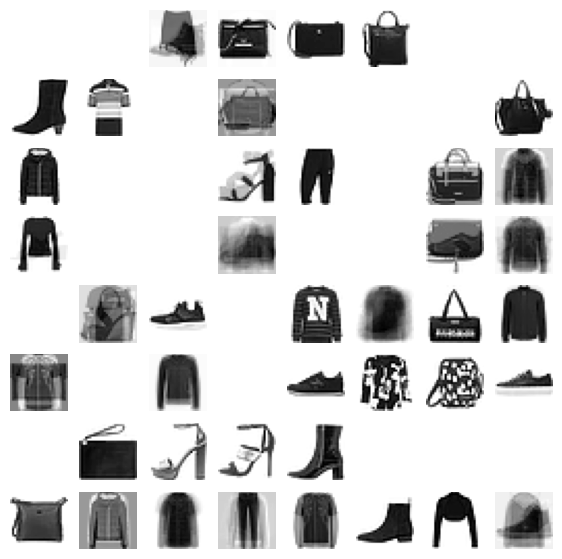

In [6]:
num_images = images_28x28.size(0)
num_cols = 8 
num_rows = math.ceil(num_images / num_cols) 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 7))
axes = axes.flatten() 

for i in range(num_images):
    axes[i].imshow(images_28x28[i].squeeze(), cmap=plt.cm.binary) 
    axes[i].axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.show()

At least 20-30 photos are in perfect condition, so the attacker could recover information from the finetuned model. This is an important disclosure attack to keep in mind, as this technique is not introducing any malware or similar technique to steal information but using the learning nature of Machine Learning. It is true that there are many training techniques that could delete the latch, as weight decay, different activation functions and others. 

Nevertheless, there could be tricky ways to overcome these issues, so the question is still there. As a result, everyone should be more responsible with the use of AI and ensure that no data is leaked through their models. 

# References
All the work developed in these notebooks is based on the theoretical work done on following paper: 
- [1] [Privacy Backdoors: Stealing Data with Corrupted Pretrained Models](https://arxiv.org/abs/2404.00473) by Shanglun Feng, Florian Tramèr, 2024. Available at: [https://arxiv.org/abs/2404.00473](https://arxiv.org/abs/2404.00473)